# Deep Learning project

The objective of this project is to learn more about:
- Optimizers: You have a variety of Algorithms available at [optim](https://pytorch.org/docs/stable/optim.html). I just want you to select one we have not used (this is, different from SGD or Adam). Use it to train the model and explain what it does.
- Loss functions: Same as before, you have a set of [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) available in pytoch for measuring the error in your classification. Again, pick a suitable one (it has to be a multi-class classification metric), explain what it does and use it. 
- Confusion Matrix: The idea is to learn how to make a visualy appealing confusion matrix that easily pinpoints the flaws of the model. You can follow this [blog](https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7) for the task. You don't need to normalise the Confusion matrix if the output size is ok, but try playing around with heatmap's `cmap` option to change colors into something appealing. 

For this task we will use the MNIST dataset (the one with the numbers) and this are the tasks: 
1. Import the data and construct `DataLoader`s for train and test (you can use the code from the Classification-with-NN.ipynb notebook in the SimpleNN folder to import the data)
2. Construct a Convolutional Neural Network
3. Decide the optimizer and loss function following the explannation above
4. Create a training loop in which you will visualize test accuracy during the process
5. The same way we did for the FashionMNIST, we want to see where did the model fail, so plot the images with the wrongly predicted labels together with the true labels
6. Follow the blog above or whatever other reference to create a beautiful confusion matrix

In [14]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
import torchmetrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn

torch.manual_seed(42)

train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [15]:
class_names = train_data.classes
class_names 

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

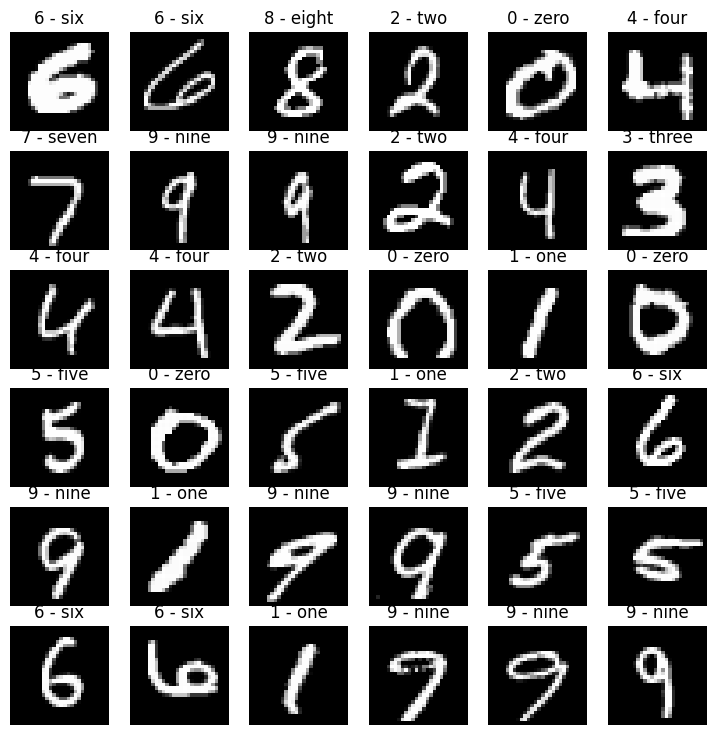

In [16]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [17]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000014DC250D940>, <torch.utils.data.dataloader.DataLoader object at 0x0000014DC1C82390>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [18]:
class NumbersMNISTModelCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default (é o passo)
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.RReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.RReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.RReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.RReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

numbersmodel = NumbersMNISTModelCNN(input_shape=1, 
                                    hidden_units=10, 
                                    output_shape=len(class_names))
numbersmodel


NumbersMNISTModelCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): RReLU(lower=0.125, upper=0.3333333333333333)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): RReLU(lower=0.125, upper=0.3333333333333333)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(params=numbersmodel.parameters(), 
                             lr=0.1) #pode variar entre 1 e 10^-4

In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1),
                                y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval() 
    with torch.inference_mode(): 
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1),
                                    y)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [21]:
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=numbersmodel, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names))
    )
    test_step(data_loader=test_dataloader,
        model=numbersmodel,
        loss_fn=loss_fn,
        accuracy_fn=torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names))
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.46693 | Train accuracy: 0.84%


 33%|███▎      | 1/3 [00:24<00:48, 24.10s/it]

Test loss: 0.16109 | Test accuracy: 0.95%

Epoch: 1
---------
Train loss: 0.14147 | Train accuracy: 0.96%


 67%|██████▋   | 2/3 [00:43<00:21, 21.53s/it]

Test loss: 0.10529 | Test accuracy: 0.97%

Epoch: 2
---------
Train loss: 0.10285 | Train accuracy: 0.97%


100%|██████████| 3/3 [01:03<00:00, 21.21s/it]

Test loss: 0.08625 | Test accuracy: 0.97%



In [22]:
# List to store mistake images
mistake_images = []

# Iterate over the test dataset and find mistakes
for images, labels in test_dataloader:
    # Forward pass through the model
    outputs = numbersmodel(images)
    
    # Get the predicted labels
    _, predicted_labels = torch.max(outputs, dim=1)
    #print(predicted_labels, labels)
    # Check if the prediction was correct
    for i in range(len(predicted_labels)):
        
        if predicted_labels[i] != labels[i]:
            mistake_images.append((images[i].squeeze(), labels[i].item(), predicted_labels[i].item()))



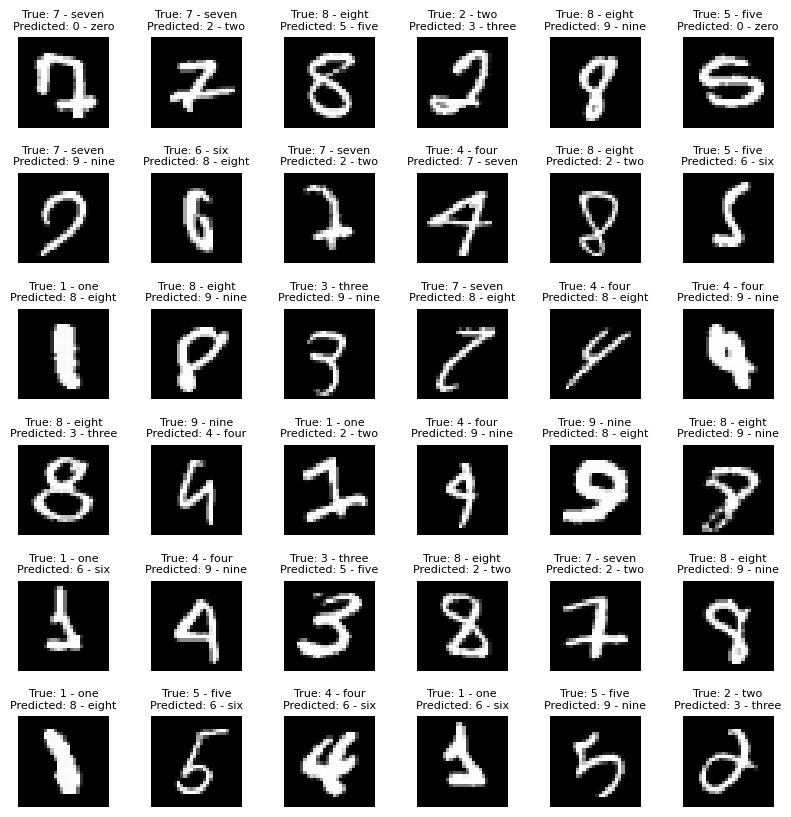

In [23]:
# Create a subplot grid for displaying the images
fig, axes = plt.subplots(6, 6, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)



# Iterate over the mistake images and plot them
for i, (image, true_label, predicted_label) in enumerate(random.sample(mistake_images, k=36)):
    # Convert the image tensor to numpy array
    image = image.numpy()
    
    # Reshape the image to its original dimensions (assuming it's flattened)
    image = np.reshape(image, (28, 28))
    
    # Plot the image along with the true and predicted labels
    ax = axes[i // 6, i % 6]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}',fontsize=8)
    ax.axis('off')

# Show the plot
plt.show()
       

<Axes: >

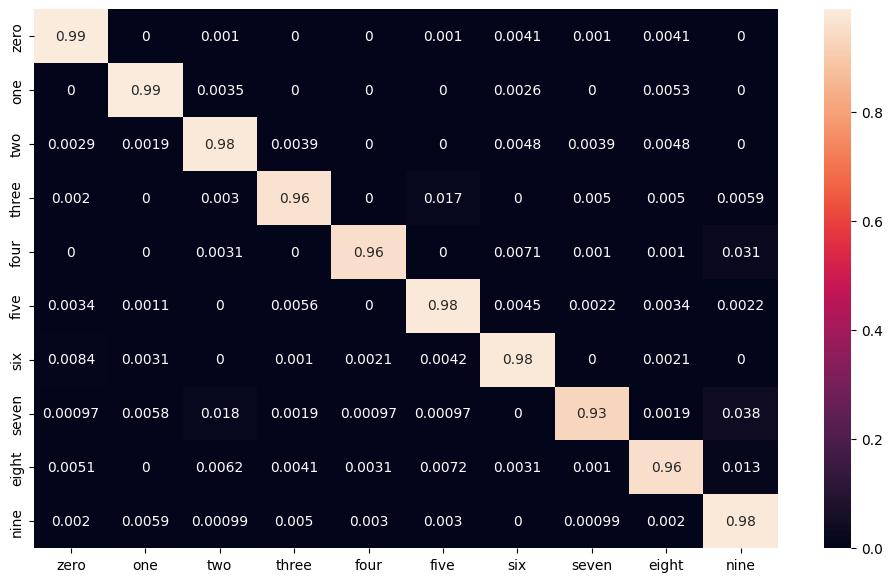

In [24]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = numbersmodel(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)